In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy
import h5py
import torch

import warnings, os

from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

from scipy.ndimage import gaussian_filter

from power import compute_power, compute_cylindrical_power

from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)
hlittle = cosmo.H0.value / 100

from astropy import units as u

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def my_savefig(fsave):
    if fsave is not None:
        plt.tight_layout()
        plt.savefig(fsave, dpi=300)
        print("Saved figure to", fsave)

def load_data(fname, ix=0, iy=0, iz=0, nx=None, ny=None, nz=None, dataname="intensity0"):
    print("Load {} (dataset: {})".format(fname, dataname))
    with h5py.File(f"{fname}", "r") as f:
        intensity = f[dataname][:]
        header = {key: f.attrs[key] for key in f.attrs}

    if nx is None:
        nx = intensity.shape[0]
    if ny is None:
        ny = intensity.shape[1]
    if nz is None:
        nz = intensity.shape[2]
    intensity = intensity[ix:ix+nx, ix:ix+ny, ix:ix+nz]
    return intensity, header

# Load data

In [2]:
### Load data
model_name = "transformer1"

snapshot_number = 33
base_dir = "../dataset/generated_data"
output_dir = "../dataset/generated_data/figures"
os.makedirs(output_dir, exist_ok=True)

sim_name = "TNG300-1"
label = ".threshold1e-3"
#label = ""
prefix_list = ["group.{}.{:d}{}".format(sim_name, snapshot_number, label), 
               "subgroup.{}.{:d}{}".format(sim_name, snapshot_number, label), 
               "group.{}.{:d}{}.{}".format(sim_name, snapshot_number, label, model_name), 
               "pinocchio.run2.threshold1e-3.low_res.{}".format(model_name), 
               "pinocchio.run2{}.{}".format(label, model_name), 
            ]
titles = ["TNG (Halo)", "TNG", "Generated", "Pinocchio", "Pinocchio"] 

titles_rsd = [ f"{t} with RSD" for t in titles ]
data_list = []
data_rsd_list = []
cat_list = []
cat_rsd_list = []

header_list = []
header_rsd_list = []   
for p in prefix_list:
    fname = "{}/{}.h5".format(base_dir, p)
    intensity, header = load_data(fname, dataname="intensity0")
    data_list.append(intensity)
    header_list.append(header)

    intensity, header = load_data(fname, dataname="intensity1")
    
    data_rsd_list.append(intensity)
    header_rsd_list.append(header)

    path = "{}/{}.cat.txt".format(base_dir, p)
    if os.path.exists(path):
        print(path)
        cat = np.loadtxt(path)
        cat_list.append(cat)
    path = "{}/{}.rsd.cat.txt".format(base_dir, p)
    if os.path.exists(path):
        print(path)
        cat_rsd = np.loadtxt(path)
        cat_rsd_list.append(cat_rsd)

diff = [ d - d_rsd for d, d_rsd in zip(data_list, data_rsd_list) ]

Load ../dataset/generated_data/group.TNG300-1.33.threshold1e-3.h5 (dataset: intensity0)
Load ../dataset/generated_data/group.TNG300-1.33.threshold1e-3.h5 (dataset: intensity1)
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-3.h5 (dataset: intensity0)
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-3.h5 (dataset: intensity1)
Load ../dataset/generated_data/group.TNG300-1.33.threshold1e-3.transformer1.h5 (dataset: intensity0)
Load ../dataset/generated_data/group.TNG300-1.33.threshold1e-3.transformer1.h5 (dataset: intensity1)
Load ../dataset/generated_data/pinocchio.run2.threshold1e-3.low_res.transformer1.h5 (dataset: intensity0)
Load ../dataset/generated_data/pinocchio.run2.threshold1e-3.low_res.transformer1.h5 (dataset: intensity1)
Load ../dataset/generated_data/pinocchio.run2.threshold1e-3.transformer1.h5 (dataset: intensity0)


# Show images

TNG 55971605.35346801
Generated 55971605.35346801
Saved figure to ../dataset/generated_data/figures/intensity_maps.png
TNG with RSD 55971605.35346801
Generated with RSD 55971605.35346801
Saved figure to ../dataset/generated_data/figures/intensity_maps_rsd.png
TNG 55971605.35346801
Generated 55971605.35346801
Saved figure to ../dataset/generated_data/figures/intensity_maps_diff.png


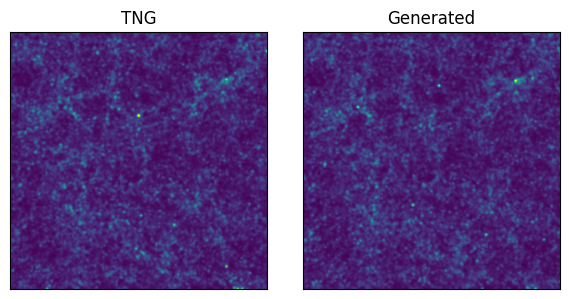

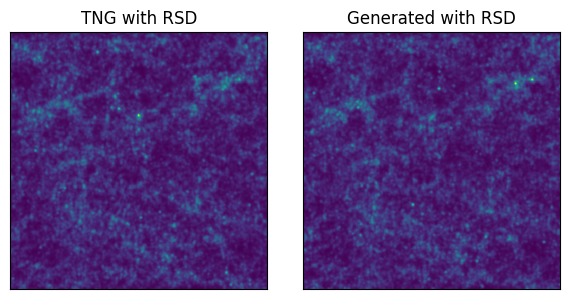

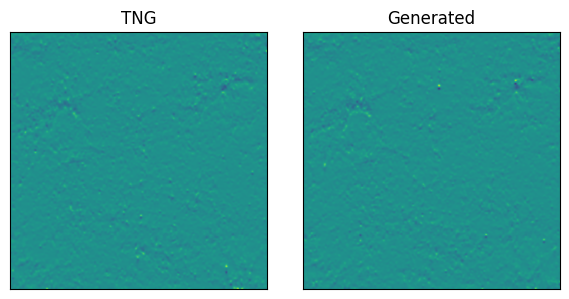

In [4]:
def show_images(data_list, titles, fsave=None, vmin=None, vmax=None, norm=None, xmin=0, ymin=0, zmin=0, nx=-1, ny=-1, nz=-1, sigma=2):

    plt.figure(figsize=(len(data_list) * 3, 3))
    for i, d in enumerate(data_list):        
        image = d[xmin:xmin+nx, ymin:ymin+ny, zmin:zmin+nz].sum(axis=1)
        image = gaussian_filter(image, sigma=sigma)

        plt.subplot(1, len(data_list), i+1)
        plt.title(titles[i])
        plt.imshow(image.T, origin="lower", interpolation="none", vmin=vmin, vmax=vmax, norm=norm)

        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()

        print(titles[i], np.sum(intensity))
        
    my_savefig(fsave)
        
fsave = "{}/intensity_maps.png".format(output_dir)
show_images(data_list[1:3], titles[1:3], fsave=fsave, vmin=0, vmax=50)
#show_images(fname_list, titles, fsave, norm=LogNorm(vmin=0.1, vmax=100))

fsave = "{}/intensity_maps_rsd.png".format(output_dir)
show_images(data_rsd_list[1:3], titles_rsd[1:3], fsave=fsave, vmin=0, vmax=50)
#show_images(fname_list, titles, fsave, norm=LogNorm(vmin=0.1, vmax=100))

fsave = "{}/intensity_maps_diff.png".format(output_dir)
show_images(diff[1:3], titles[1:3], fsave=fsave, vmin=-50, vmax=50)

Saved figure to ../dataset/generated_data/figures/intensity_maps_pinocchio.png
Saved figure to ../dataset/generated_data/figures/intensity_maps_pinocchio_rsd.png


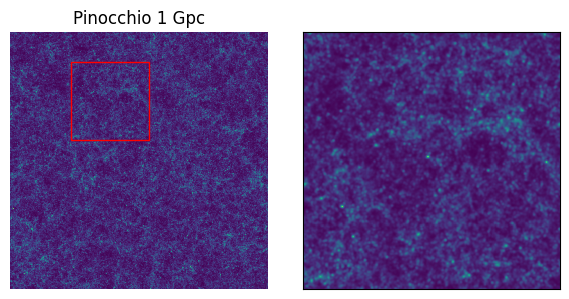

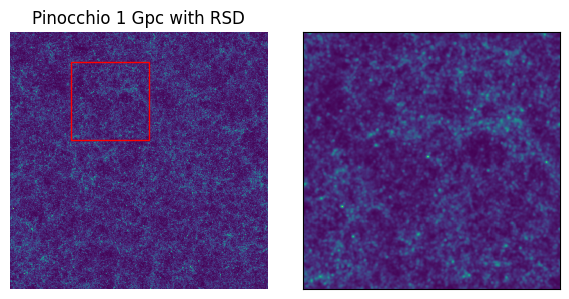

In [5]:
zoom_size = data_list[0].shape[0]
def show_images_with_zoom(data, title, fsave=None):
    image = data[:,:zoom_size,:].sum(axis=1)
    image = gaussian_filter(image, sigma=2)
    image = image.T 

    x0, y0 = 400, 200  # upper left corner of the zoomed area
    zoom = image[y0:y0+zoom_size, x0:x0+zoom_size]

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    axes[0].imshow(image, vmin=0, vmax=50, interpolation="none")
    axes[0].set_title(title)
    axes[0].add_patch(plt.Rectangle((x0, y0), zoom_size, zoom_size, edgecolor='red', facecolor='none', linewidth=1))
    axes[0].set_aspect('equal')
    axes[0].axis('off')

    axes[1].imshow(zoom, vmin=0, vmax=50, interpolation="none")
    #axes[1].set_title("Zoom up")
    #axes[1].add_patch(plt.Rectangle((0, 0), zoom_size, zoom_size, edgecolor='red', facecolor='none', linewidth=3, zorder=10))
    #for spine in axes[1].spines.values():
    #    spine.set_edgecolor('red')
    #    spine.set_linewidth(1) 
    axes[1].set_aspect('equal')
    axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    my_savefig(fsave)

fsave = "{}/intensity_maps_pinocchio.png".format(output_dir)
show_images_with_zoom(data_list[-1], title="Pinocchio 1 Gpc", fsave=fsave)

fsave = "{}/intensity_maps_pinocchio_rsd.png".format(output_dir)
show_images_with_zoom(data_list[-1], title="Pinocchio 1 Gpc with RSD", fsave=fsave)


# Power Spectrum

In [ ]:
### Compute power spectrum
k_list = []
power_list = []
for data, header in zip(data_list[:4], header_list):
    boxsize = header["boxsize"] / hlittle # Mpc
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    power, k, var = compute_power(data / voxel_size, boxlength=boxsize, log_bins=True)

    k_values = 0.5 * (k[1:] + k[:-1])
    power_list.append(power)
    k_list.append(k_values)

power_rsd_list = []
for data, header in zip(data_rsd_list[:4], header_rsd_list):
    boxsize = header["boxsize"] / hlittle
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    power, k, var = compute_power(data / voxel_size, boxlength=boxsize, log_bins=True)

    k_values = 0.5 * (k[1:] + k[:-1])
    power_rsd_list.append(power)
    k_list.append(k_values)

power.py:84: RuntimeWarning: invalid value encountered in divide


power.py:84: RuntimeWarning: invalid value encountered in divide


power.py:84: RuntimeWarning: invalid value encountered in divide


power.py:84: RuntimeWarning: invalid value encountered in divide


power.py:84: RuntimeWarning: invalid value encountered in divide


power.py:84: RuntimeWarning: invalid value encountered in divide


Saved figure to ../dataset/generated_data/figures/power_spectrum.pdf
Saved figure to ../dataset/generated_data/figures/power_spectrum_pinocchio.pdf


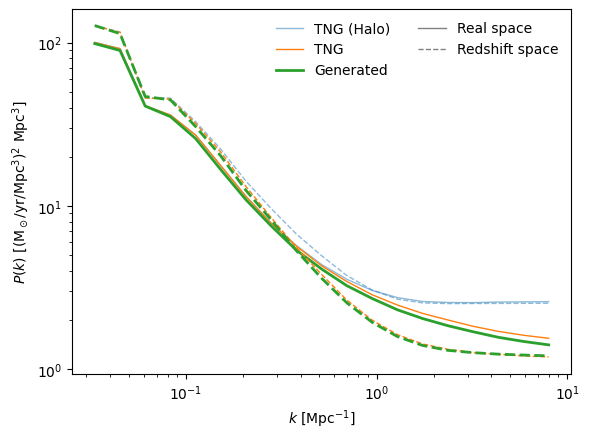

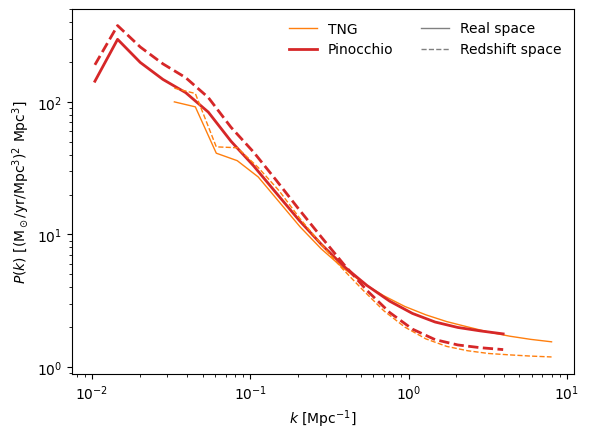

In [7]:
### Show Power spectrum  
def plot_power(k_list, power_list, header_list, titles=None, ls=None, color=None, zorder=0, alpha=None, id_list=None, lw_list=None, with_factor=False):
    ndata = len(data_list)
    if not isinstance(titles, list):
        titles = [titles] * len(data_list)
    if not isinstance(ls, list):
        ls = [ls] * len(data_list)
    if not isinstance(color, list):
        color = [color] * len(data_list)
    if not isinstance(zorder, list):
        zorder = [zorder] * len(data_list)
    if not isinstance(alpha, list):
        alpha = [alpha] * len(data_list)
    if id_list is None:
        id_list = range(len(data_list))
    if not isinstance(lw_list, list):
        lw_list = [1] * len(data_list)

    for count, i in enumerate(id_list):
        k_values = k_list[i]
        if with_factor:
            power = power_list[i] *  (k_values**3) / (2 * np.pi**2)  # Convert to Mpc^3 units
        else:
            power = power_list[i] 

        plt.plot(k_values[1:], power[1:], label=titles[i], ls=ls[i], color=color[i], zorder=zorder[i], alpha=alpha[i], lw=lw_list[i])
        #plt.errorbar(k_values, power, yerr=np.sqrt(var), fmt="o")

with_factor = False
    
def compare_power(id_list, fsave, **kwargs):

    plt.figure(figsize=(6, 4.5))
    alpha = [0.5, 1, 1, 1]
    
    plot_power(k_list, power_list, header_list, titles, ls="solid", color=colors, id_list=id_list, alpha=alpha, with_factor=with_factor, **kwargs)
    plot_power(k_list, power_rsd_list, header_rsd_list, ls="dashed", color=colors, id_list=id_list, alpha=alpha, with_factor=with_factor, **kwargs)
    
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")

    if with_factor:
        plt.ylabel(r"$k^3P(k)/2\pi^2\ [({\rm M_\odot / yr /Mpc^3})^2]$")
    else:
        #plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr)^2 / Mpc^3]}$")
        plt.ylabel(r"$P(k)\ [({\rm M_\odot / yr / Mpc^3)^2 \ Mpc^3]}$")
    plt.yscale("log")
    plt.xscale("log")

    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
    plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.legend(frameon=False, ncol=2)
    my_savefig(fsave)

fsave = "{}/power_spectrum.pdf".format(output_dir)
compare_power([0, 1, 2], fsave=fsave, lw_list=[1,1,2])

fsave = "{}/power_spectrum_pinocchio.pdf".format(output_dir)
compare_power([1, 3], fsave=fsave, lw_list=[1,1,1,2])


In [3]:
k_perp_list = []
k_para_list = []
power2d_list = []
for data, header in zip(data_list[:3], header_list):
    boxsize = header["boxsize"] / hlittle
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    power2d, k_perp, k_para, var = compute_cylindrical_power(data / voxel_size, boxlength=boxsize, nbins=12, log_bins=True, use_same_bins=True)

    power2d_list.append(power2d)
    k_perp_list.append(k_perp)
    k_para_list.append(k_para)

power2d_rsd_list = []
for data, header in zip(data_rsd_list[:3], header_rsd_list):
    boxsize = header["boxsize"] / hlittle
    voxel_size = boxsize ** 3 / data.shape[0] / data.shape[1] / data.shape[2]
    power2d, kx, ky, var = compute_cylindrical_power(data / voxel_size, boxlength=boxsize, nbins=12, log_bins=True, use_same_bins=True)

    power2d_rsd_list.append(power2d)

power.py:191: RuntimeWarning: invalid value encountered in divide


power.py:191: RuntimeWarning: invalid value encountered in divide


power.py:191: RuntimeWarning: invalid value encountered in divide


power.py:191: RuntimeWarning: invalid value encountered in divide


power.py:191: RuntimeWarning: invalid value encountered in divide


power.py:191: RuntimeWarning: invalid value encountered in divide


/tmp/ipykernel_1042641/1857567685.py:26: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour(X, Y, power2d, levels=[1.5, 3, 10], colors="k", ls="dashed", alpha=0.5)
/tmp/ipykernel_1042641/485979937.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to ../dataset/generated_data/figures/cylindrical_power_spectrum.pdf


/tmp/ipykernel_1042641/1857567685.py:26: UserWarning: The following kwargs were not used by contour: 'ls'
  ax.contour(X, Y, power2d, levels=[1.5, 3, 10], colors="k", ls="dashed", alpha=0.5)
/tmp/ipykernel_1042641/485979937.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to ../dataset/generated_data/figures/cylindrical_power_spectrum_rsd.pdf


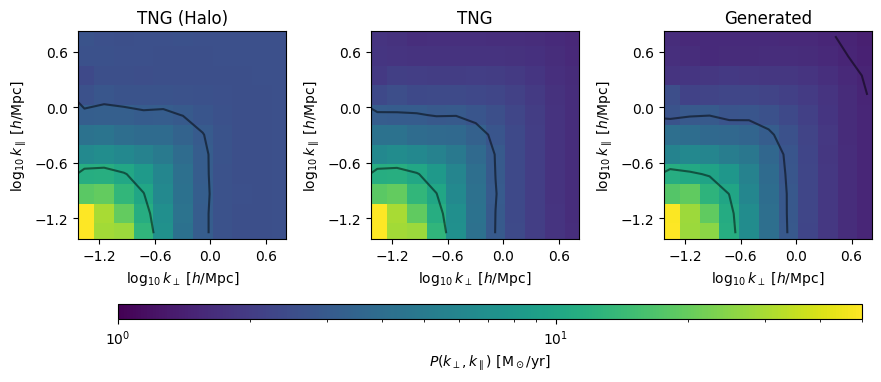

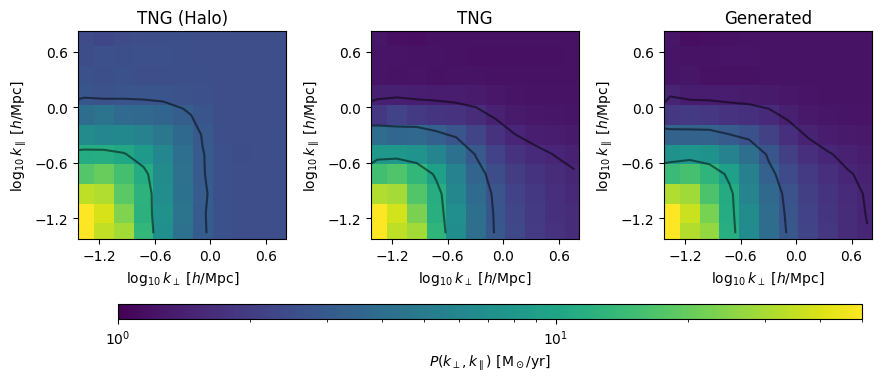

In [9]:
### Cylindrical power spectrum  
def plot_cylindrical_power(id_list, power2d_list, fsave=None):
    ndata = len(id_list)
    fig, axes = plt.subplots(1, ndata, figsize=(4*ndata, 4))
    plt.subplots_adjust(wspace=-0.9)

    for count, i in enumerate(id_list):
        k_perp = k_perp_list[i]
        k_para = k_para_list[i]
        power2d = power2d_list[i]
        
        log_k_perp = np.log10(k_perp)
        log_k_para = np.log10(k_para)

        ax = axes[count]
        ax.set_aspect("equal")
        ax.set_title(titles[i])
        

        vmin, vmax = 1, 50
        im = ax.pcolormesh(log_k_perp, log_k_para, power2d, shading="auto", norm=LogNorm(vmin=vmin, vmax=vmax))
        
        log_k_perp_values = 0.5 * (log_k_perp[1:] + log_k_perp[:-1])
        log_k_para_values = 0.5 * (log_k_para[1:] + log_k_para[:-1])
        X, Y = np.meshgrid(log_k_perp_values, log_k_para_values)
        ax.contour(X, Y, power2d, levels=[1.5, 3, 10], colors="k", ls="dashed", alpha=0.5)

        ax.set_xlabel(r"$\log_{10} k_\perp \ [h/ \rm Mpc]$")
        ax.set_ylabel(r"$\log_{10} k_\parallel \ [h/ \rm Mpc]$")

        ax.set_xlim(-1.43, 0.82)
        ax.set_ylim(-1.43, 0.82)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))  # 最大4本
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

    cbar = fig.colorbar(im, ax=axes, orientation="horizontal", aspect=50, pad=-0.45, shrink=0.8)
    cbar.set_label(r"$P(k_\perp, k_\parallel) \ [{\rm M_\odot / yr }]$")

    my_savefig(fsave)


plot_cylindrical_power([0, 1, 2], power2d_list, fsave="{}/cylindrical_power_spectrum.pdf".format(output_dir))
plot_cylindrical_power([0, 1, 2], power2d_rsd_list, fsave="{}/cylindrical_power_spectrum_rsd.pdf".format(output_dir))

# Voxel Intensity Distribution

/tmp/ipykernel_1042148/3250654029.py:8: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(data / voxel_size).flatten()


Saved figure to ../dataset/generated_data/figures/intensity_histogram.pdf


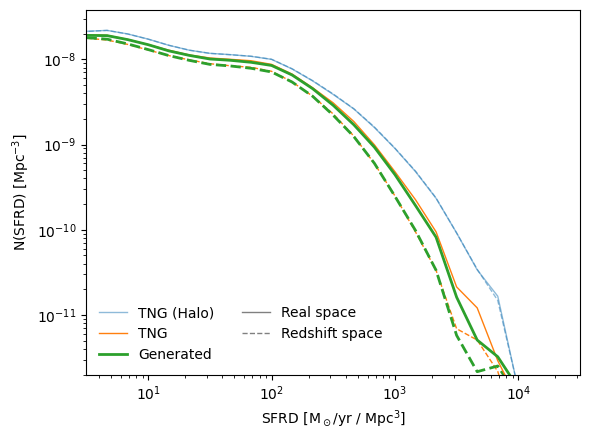

In [9]:
def plot_vid(data_list, header_list, titles, **kwargs):
    lw_list = [1, 1, 2]
    alpha = [0.5, 1, 1, 0.5, 1]
    for i, (data, header) in enumerate(zip(data_list, header_list)):
        boxsize = header["boxsize"] # Mpc/h
        voxel_size = boxsize**3 / (data.shape[0] * data.shape[1] * data.shape[2])
        volume = (boxsize / hlittle) **3 
        value = np.log10(data / voxel_size).flatten()
        hist = np.histogram(value, bins=30, range=(-0.5, 4.5), density=True)

        x = 10 **hist[1][:-1] 
        plt.plot(x, hist[0]/volume, label=titles[i], color=colors[i], alpha=alpha[i], lw=lw_list[i], **kwargs)
#plt.hist(value, range=(1, 3.5), bins=30, weights=np.ones_like(value/volume, histtype="step", label=titles[i])
        

plt.figure(figsize=(6, 4.5))
plot_vid(data_list[:3], header_list, titles)
plot_vid(data_rsd_list[:3], header_rsd_list, [None]*10, ls="--", zorder=-10)

plt.xlabel(r"${\rm SFRD\ [M_\odot / yr \ / \ Mpc^3}]$")
plt.ylabel(r"$\rm N(SFRD)\ [Mpc^{-3}]$")

plt.xscale("log")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()
xlim = (10**0.5, 10**4.5)
ylim = (2e-12, ylim[1])

plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(frameon=False, ncol=2)

fsave = "{}/intensity_histogram.pdf".format(output_dir)
my_savefig(fsave)

# Plot Galaxy Catalog

In [10]:
for i, cat in enumerate(cat_list):
    plt.figure()
    plt.title(titles[i])
    
    x = cat[:, 0]
    y = cat[:, 1]
    z = cat[:, 2]

    plt.scatter(x, y, s=1, label=titles[i], alpha=0.5)
    print(len(x))

    plt.xlim(0, x.max())
    plt.ylim(0, y.max())
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

import numpy as np
from scipy.spatial import cKDTree

def two_point_cf(points, rbin, boxsize):

    N = points.shape[0]

    tree = cKDTree(points)
    pairs = tree.query_pairs(rbin[-1], output_type='ndarray')
    dists = np.linalg.norm(points[pairs[:, 0]] - points[pairs[:, 1]], axis=1)
    DD, _ = np.histogram(dists, bins=rbin)

    shell_volume = (rbin[1:]**3 - rbin[:-1]**3)
    total_volume = boxsize**3
    total_pairs = N * (N - 1) / 2
    RR = total_pairs * shell_volume / total_volume

    RR_safe = np.where(RR == 0, 1e-10, RR)
    eta = DD / RR_safe
    xi = eta - 1
    return xi

bins = np.logspace(-2, 2, 20)
bin_values = 0.5 * (bins[1:] + bins[:-1])

plt.figure(6, 4.5)

for i, cat in enumerate(cat_list):
    if i == 0:
        continue
    corr = two_point_cf(cat, bins, boxsize=205)
    plt.plot(bin_values, corr, color=colors[i], label=titles[i])

labels = ["RSD"] + [None] * 10
for i, cat in enumerate(cat_rsd_list):
    if i == 0:
        continue
    corr = two_point_cf(cat, bins, boxsize=205)
    plt.plot(bin_values, corr, color=colors[i], ls="--", label=labels[i])

plt.xscale("log")
plt.yscale("log")

xlim = plt.xlim()
ylim = plt.ylim()
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="solid", lw=1, label="Real space")
plt.plot([0, 1], [ylim[0]*0.1, ylim[0]*0.1], color="gray", ls="dashed", lw=1, label="Redshift space")
plt.xlim(xlim)
plt.ylim(ylim)


plt.xlabel(r"$\log r [{\rm Mpc}/h$")
plt.ylabel(r"$\xi(r) + 1$")    
plt.legend(frameon=False, ncol=2)


# Contribution to total intensity

Load ../dataset/generated_data/subgroup.TNG300-1.33.h5
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-2.h5
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1e-1.h5
Load ../dataset/generated_data/subgroup.TNG300-1.33.threshold1.h5
[np.float64(0.010574212205776956), np.float64(0.01056974142608914), np.float64(0.010488072330154766), np.float64(0.009725713219973082)]
0.00042297909736754846
0.00821312753293335


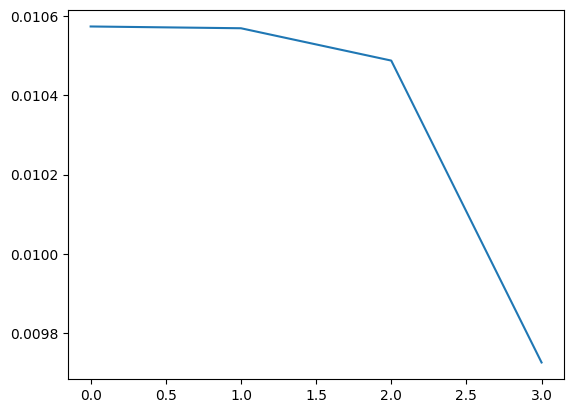

In [34]:
threshold_list = ["", ".threshold1e-2", ".threshold1e-1", ".threshold1"]
prefix = "../dataset/generated_data/subgroup.TNG300-1.33"
mean = []
for th in threshold_list:
    intensity, header = load_data(f"{prefix}{th}.h5")
    mean.append(intensity.mean())

print(mean)
plt.plot(mean)
print(mean[0]/mean[1] - 1)
print(mean[0]/mean[2] -1)